<a href="https://colab.research.google.com/gist/akcgjc007/51b0693b8015ecdc139f1c2b3ceb82ea/copy-of-tensorflow-on-chars74k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Developer docs
# https://www.tensorflow.org/tutorials/keras/classification
# https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Importing modules
from os import listdir, system
import pandas as pd
import numpy as np
import sys
import time

import cv2 as cv2
import imutils
import imageio
import pickle
from IPython.display import clear_output

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from skimage.io import imread
#from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import regionprops
from skimage.transform import resize
from scipy import ndimage


# Downloading dataset from: http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
# You can comment this after running once.
# !wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
# !tar -xvzf ./EnglishImg.tgz
# !git clone https://github.com/captcha-breakers/ubiquitous-pancake.git

In [25]:
# Setting up folders
base_dir = "./English/Img/GoodImg/Bmp/"
folders = listdir(base_dir)
folders.sort()
folders = folders[10:36]
print(folders)

# Setting image_size
image_size = (20, 20)

['Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036']


In [26]:
# Collecting images from folders
data = []
total_images = 0
for i in folders:
    all_images = listdir(base_dir+i)
    total_images+=len(all_images)
    currentlabel = int(i[6:])-11

    for name in all_images:
        image = cv2.imread(base_dir+i+"/"+name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, image_size)

        # Filtering
        image = cv2.GaussianBlur(image,(5,5),0)
        image = cv2.Laplacian(image,cv2.CV_64F)
        image = cv2.GaussianBlur(image,(5,5),0)
        kernel = np.ones((3, 3), np.uint8)
        image = cv2.filter2D(image,-1,kernel)
        # image = cv2.medianBlur(image,5)
        # image = cv2.dilate(image,kernel,iterations = 1)
        # image = cv2.erode(image,kernel,iterations = 1)
        # image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        # image = cv2.filter2D(image,-1,kernel)
        # image = cv2.blur(image,(5,5))

        data.append((image/255, currentlabel))
print("Total images: ", total_images)

Total images:  5202


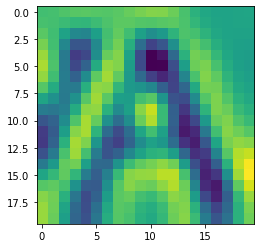

In [27]:
# Visualizing images
imshow(data[6][0])

In [28]:
# Shuffling data & making train/test
np.random.shuffle(data)
n = len(data)
p = int(80*n/100)

train_images = []
train_labels = []
test_images = []
test_labels = []
for i in range(n):
    if i<p:
        train_images.append(data[i][0])
        train_labels.append(data[i][1])
    else:
        test_images.append(data[i][0])
        test_labels.append(data[i][1])

In [37]:
# Making the model and training it
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=image_size),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(26)
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.fit(np.array(train_images), np.array(train_labels), epochs=20, batch_size=10)

Epoch 1/20
417/417 [==============================] - 1s 1ms/step - loss: 2.3813 - accuracy: 0.3500
Epoch 2/20
417/417 [==============================] - 1s 1ms/step - loss: 0.8710 - accuracy: 0.7510
Epoch 3/20
417/417 [==============================] - 1s 1ms/step - loss: 0.5833 - accuracy: 0.8347
Epoch 4/20
417/417 [==============================] - 1s 1ms/step - loss: 0.4285 - accuracy: 0.8803
Epoch 5/20
417/417 [==============================] - 1s 1ms/step - loss: 0.2808 - accuracy: 0.9161
Epoch 6/20
417/417 [==============================] - 1s 1ms/step - loss: 0.2053 - accuracy: 0.9442
Epoch 7/20
417/417 [==============================] - 1s 1ms/step - loss: 0.2942 - accuracy: 0.9224
Epoch 8/20
417/417 [==============================] - 1s 1ms/step - loss: 0.1555 - accuracy: 0.9584
Epoch 9/20
417/417 [==============================] - 1s 1ms/step - loss: 0.1401 - accuracy: 0.9545
Epoch 10/20
417/417 [==============================] - 1s 1ms/step - loss: 0.1532 - accuracy: 0.9566

In [38]:
system("mkdir -p models")
# model.save('./models/my_model_84.h5')

# Predicting on test images
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(np.array(test_images))

p=0
for i in range(len(test_images)):
  if np.argmax(predictions[i]) == test_labels[i]:
    p+=1

print("Test accuracy: ", 100*p/len(test_images))

Test accuracy:  83.28530259365995


In [39]:
fil_dir = "./ubiquitous-pancake/captchas/"
ct = 0
p = 0
n = 0
for fil in listdir(fil_dir)[:100]:
  image = cv2.imread(fil_dir + fil)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

  cnts, new = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
  new_image = cv2.drawContours(image,cnts,-1,(0,255,0),1)

  mea_image = []
  mea_image.append(thresh[:, :])
  captcha = np.invert(mea_image[0])
  labelled_captcha = measure.label(captcha)

  character_dimensions = (0.20*captcha.shape[0], 0.8*captcha.shape[0], 0.03*captcha.shape[1], 0.25*captcha.shape[1])
  min_height, max_height, min_width, max_width = character_dimensions

  characters = []
  charactersx = []
  counter=0
  column_list = []
  row_list = []
  i = 0
  for regions in regionprops(labelled_captcha):
      y0, x0, y1, x1 = regions.bbox
      region_height = y1 - y0
      region_width = x1 - x0

      if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
          roi = captcha[y0:y1, x0:x1]
          resized_char = cv2.copyMakeBorder(roi, 5, 5, 5, 5, cv2.BORDER_CONSTANT)
          resized_char = resize(roi, (20, 20))
          column_list.append(x0)
          characters.append(resized_char)
  counter = 0

  classification_result = []
  for each_character in characters:
      x_p,y_p = 2,2
      each_character = cv2.copyMakeBorder(each_character, x_p, x_p, y_p, y_p, cv2.BORDER_CONSTANT)
      each_character = cv2.GaussianBlur(each_character,(5,5),0)
      each_character = cv2.Laplacian(each_character,cv2.CV_64F)
      each_character = cv2.GaussianBlur(each_character,(5,5),0)
      
      each_character = cv2.resize(each_character,(20,20))

      kernel = np.ones((3, 3), np.uint8)
      each_character = cv2.filter2D(each_character,-1,kernel)
      cv2.waitKey(1000)
      each_character = each_character.reshape(1, -1);
      result,  = probability_model.predict([each_character])
      label = ord(fil[counter]) - 65
      if(label == np.argmax(result)):
        p += 1
      else:
        n+=1
      classification_result.append(result)
      counter += 1
  
  ct += 1
  print("Current file: ", ct)
  clear_output(wait=True)
  
print("Postive predictions: ", p)
print("Negetive predictions: ", n)
print("Accuracy: ", p*100/(p+n))

Postive predictions:  481
Negetive predictions:  85
Accuracy:  84.98233215547704
